# PoroTomo DAS Data Processing Tutorial for hdf5 Files
Prior to running this script, make sure the following are installed within your Python environment:
 - boto3
 - numpy
 - matplotlib
 - pandas
 - h5py or h5pyd (HSDS)
 - s3fs
 - sys
 - os
    
After installation, run the following:

In [1]:
import boto3, os, logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import os

import s3fs
import h5py
import h5pyd

boto3.set_stream_logger('boto3', logging.INFO)
s3 = boto3.resource('s3')
bucket = s3.Bucket('porotomo-hdf5')
cwd = os.getcwd()

## Showing Info for PoroTomo AWS S3 Bucket

In [2]:
s3.meta.client.head_bucket(Bucket='porotomo-hdf5')

{'ResponseMetadata': {'RequestId': 'DKEKEX2M1KEQ1K6T',
  'HostId': 'o1D+YeNrsgVgDNk+zgUKsrhMw7aWfGdZ6i6njR00tJ7G+tQh4YVe5toyJKRDhJzrbYv8nCMJvfQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'o1D+YeNrsgVgDNk+zgUKsrhMw7aWfGdZ6i6njR00tJ7G+tQh4YVe5toyJKRDhJzrbYv8nCMJvfQ=',
   'x-amz-request-id': 'DKEKEX2M1KEQ1K6T',
   'date': 'Mon, 14 Sep 2020 23:28:05 GMT',
   'x-amz-bucket-region': 'us-west-2',
   'content-type': 'application/xml',
   'server': 'AmazonS3',
   'connection': 'close'},
  'RetryAttempts': 0}}

## Total Number of Objects in PoroTomo S3 Bucket
This code block shows the total number of objects within the bucket. For the purposes of this tutorial, we will use only two data files from 3/15, including and following a 'mystery event.'

In [3]:
count = 0
for object in bucket.objects.all():
    count+=1
    
count

8468

## Accessing the Data using h5py
This can be done by pulling the data directly into the notebook from S3.

The files used in this tutorial are specified here:

In [4]:
keys = ['H5/DASH/20160315/PoroTomo_iDAS16043_160315083149.h5',
        'H5/DASH/20160315/PoroTomo_iDAS16043_160315083219.h5']


In [5]:
data_stream = []
s3 = s3fs.S3FileSystem()
print('hdf5 file structures:')
for key in keys:
    path = 's3://nrel-pds-porotomo/'+key
    with s3.open(path, 'rb') as fp:
        with h5py.File(fp, 'r') as f:
            das = np.array(f['das'])
            data_stream.append(das)
            print(list(f))


hdf5 file structures:
['channel', 'crs', 'das', 't', 'trace', 'x', 'y', 'z']
['channel', 'crs', 'das', 't', 'trace', 'x', 'y', 'z']


## Accessing the Data via HSDS and h5pyd
### NREL Highly Scalable Data Service (HSDS)
This service operates with the HSDS software developed by the [HDF Group](https://www.hdfgroup.org/) and is hosted on Amazon Web Services (AWS) using a combination of EC2 (Elastic Compute) and S3 (Scalable Storage Service). You can read more about the HSDS service [in this slide deck](https://www.slideshare.net/HDFEOS/hdf-cloud-services).

### How to Use

Install the h5pyd library:

```
pip install h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

You can also add the above contents to a configuration file at ~/.hscfg

In [6]:
path = '/nrel/porotomo/DASH/PoroTomo_iDAS16043_20160315.h5'

The files available via HSDS are stored by day. Here, we'll access a smsall portion of the file from March 15. The file number specified below represents the number of the first 30 second hdf5 file imported above using h5py that includes the mystery event. The 30 second files are not available via HSDS, but are available here: https://s3.console.aws.amazon.com/s3/buckets/nrel-pds-porotomo/H5/DASH/20160315/?region=us-west-2&tab=overview. The length of the file specified below represents the length of one of these files.


In [15]:
file_num = 123+900  # file number
file_len = 30000    # file length
event_loc = file_num*file_len

Below, we read in the portion of the March 15 file using h5py and HSDS.

In [16]:
with h5pyd.File(path, 'r') as f:
    das = np.array(f['das'][event_loc:event_loc+file_len])
    data_stream.append(das)
    print
    print(list(f))

['channel', 'crs', 'das', 't', 'trace', 'x', 'y', 'z']


## Plotting Raw Data
### Plotting Individual Traces
Individual traces within a stream can be accessed by accessing individual columns of the numpy arrays. In this code block, a subset of the traces are placed into an array and plotted to show change in amplitude over time at different positions along the cable.

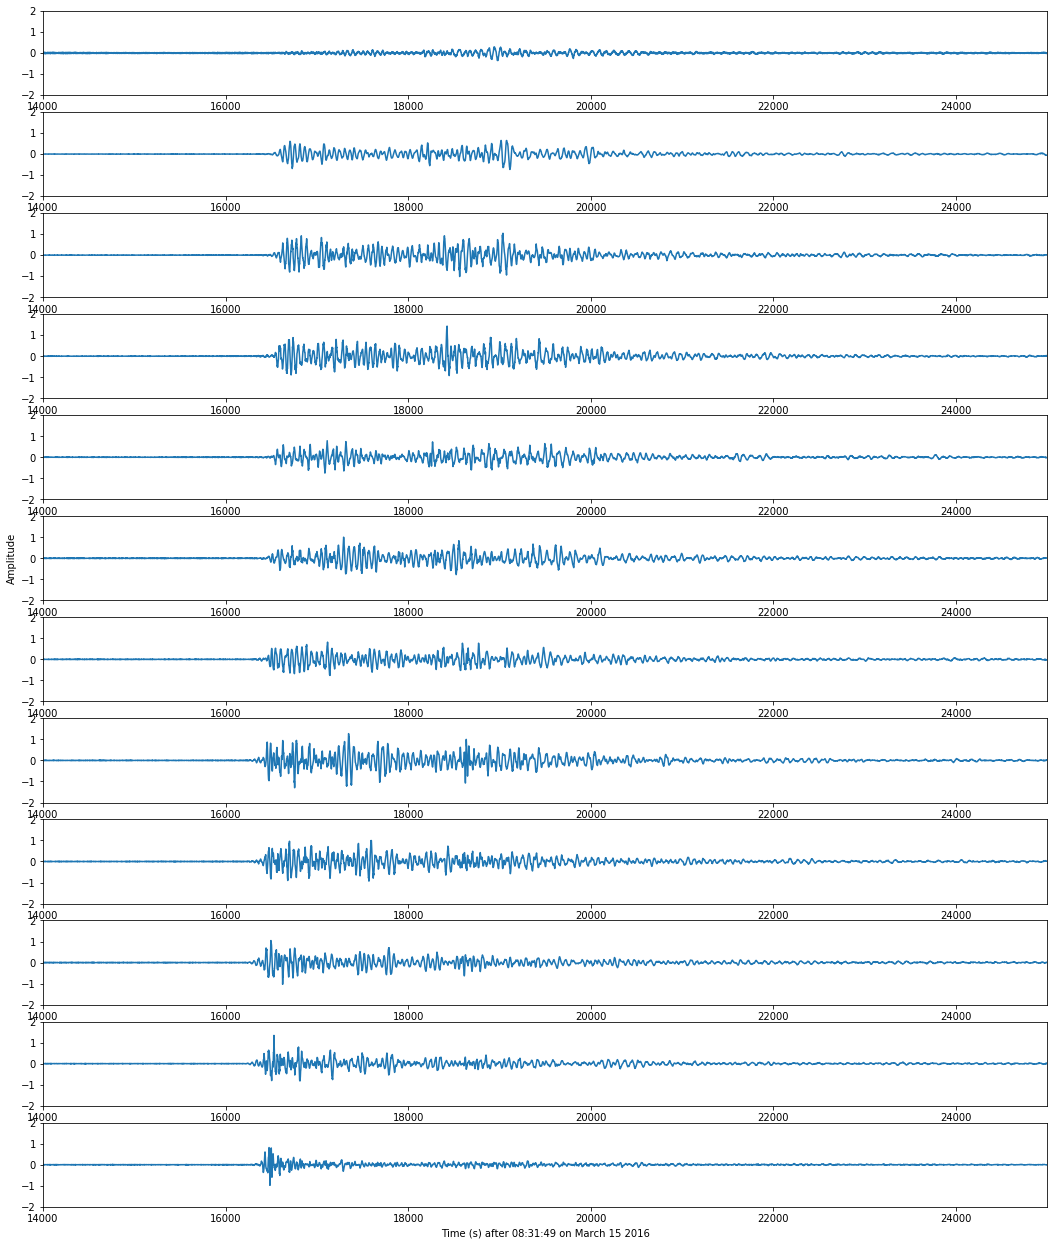

In [17]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12
ylim = [-2,2]; xlim=[14000,25000]
data = data_stream[0]

for index in np.arange(num_traces):
    traces.append(data[:,start_trace+trace_inc*index])
    
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(traces[trace_no].data); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax2.plot(traces[trace_no].data); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax3.plot(traces[trace_no].data); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax4.plot(traces[trace_no].data); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax5.plot(traces[trace_no].data); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax6.plot(traces[trace_no].data); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax6.set_ylabel('Amplitude')
ax7.plot(traces[trace_no].data); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax8.plot(traces[trace_no].data); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax9.plot(traces[trace_no].data); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax10.plot(traces[trace_no].data); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax11.plot(traces[trace_no].data); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax12.plot(traces[trace_no].data); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
ax12.set_xlabel('Time (s) after 08:31:49 on March 15 2016')
plt.show()
    

### Size of Data

In [18]:
raw_data = data_stream
size = sys.getsizeof(raw_data[0])+sys.getsizeof(raw_data[1])+sys.getsizeof(raw_data[2])
print("size of three raw datasets: {:.4f} GB".format(size*10**-9))

raw_data = []
raw_data.append(data_stream[0].T)
raw_data.append(data_stream[1].T)
raw_data.append(data_stream[2].T)


size of three raw datasets: 3.1396 GB


### Determining Upper and Lower Limits of the Data
In order to determine upper and lower bounds for the colorbar, the 99th percentile, maximum value, and standard deviation are calculated. 

In [19]:
vm0 = np.percentile(raw_data[0], 99)
std0 = np.std(raw_data[0])
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm0, raw_data[0].max(),std0))


The 99th percentile is 0.0397; the max amplitude is 2.4027; the standard deviation is  0.0292


In [20]:
vm1 = np.percentile(raw_data[1], 99)
std1 = np.std(raw_data[1])
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm1, raw_data[1].max(),std1))


The 99th percentile is 0.0134; the max amplitude is 2.0574; the standard deviation is  0.0193


In [ ]:
vm2 = np.percentile(raw_data[2], 99)
std2 = np.std(raw_data[2])
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm2, raw_data[2].max(),std2))


### Plotting all Traces as an Image Using imshow

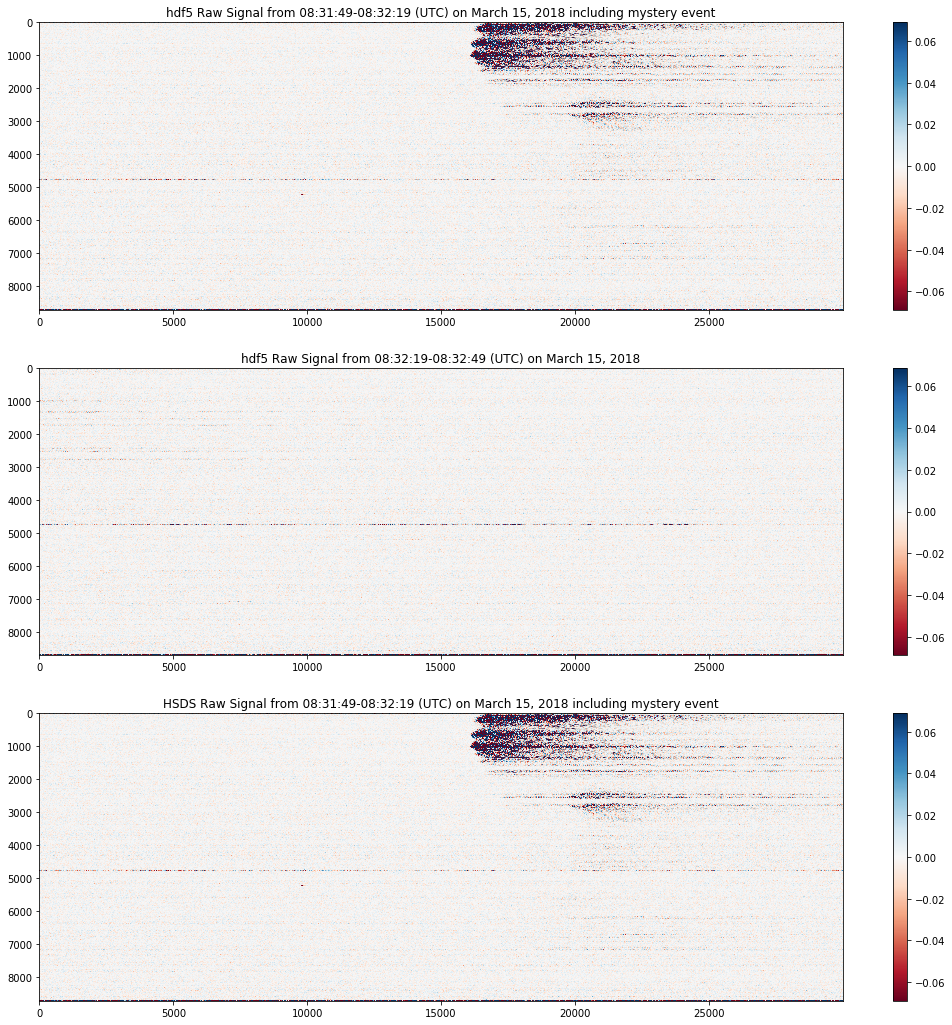

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(18,18))
mystery_event = ax1.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(mystery_event,ax=ax1)
ax1.set_title('hdf5 Raw Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018 including mystery event')

noise = ax2.imshow(raw_data[1], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(noise,ax=ax2)
ax2.set_title('hdf5 Raw Signal from 08:32:19-08:32:49 (UTC) on March 15, 2018')

mystery_event_hsds = ax3.imshow(raw_data[2], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(mystery_event_hsds,ax=ax3)
ax3.set_title('HSDS Raw Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018 including mystery event')
plt.show()

### Isolating the Mystery Event

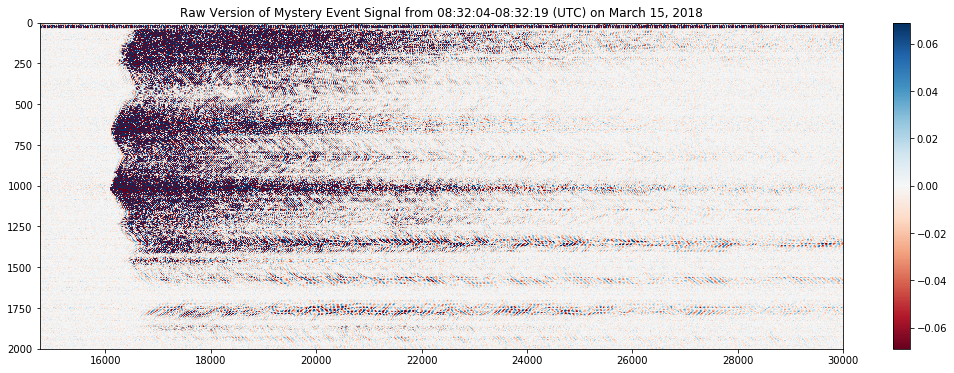

In [14]:
plt.figure(figsize=(18,6))
mystery_event = plt.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.xlim(14750,30000)
plt.ylim(2000,0)

plt.colorbar(mystery_event)
plt.title('Raw Version of Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
plt.show()